In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import classification_report, mean_squared_error, roc_auc_score, r2_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Load the data
calendar_df = pd.read_csv('data/calendar_preprocessed.csv')
gps_df = pd.read_csv('data/gps_data_preprocessed.csv')
roster_df = pd.read_csv('data/roster_preprocessed.csv')
wellness_df = pd.read_csv('data/wellness_preprocessed.csv')


In [3]:
# Preprocessing and merging datasets
merged_df = pd.merge(gps_df, wellness_df, how='left', on=['Player Name', 'Session Date'])
merged_df = pd.merge(merged_df, calendar_df, how='left', left_on='Session Date', right_on='Date')
merged_df = pd.merge(merged_df, roster_df[['Player Name', 'Position', 'Max Game Total Distance', 'Max Game High Speed Running']], how='left', on='Player Name')


In [ ]:
# Remove redundant or less informative features
features = merged_df[['Accelerations Zone 5', 'Accelerations Zone 6', 'Decelerations Zone 5', 
                      'Decelerations Zone 6', 'HML Distance', 'HML Efforts', 'Explosive Distance',
                      'Average Step Impact Left (g)', 'Average Step Impact Right (g)', 'Step Balance']]

# Convert categorical features like 'Position' into numerical values using one-hot encoding
features = pd.get_dummies(features, columns=['Position'], drop_first=True)


KeyError: "None of [Index(['Position'], dtype='object')] are in the [columns]"

In [5]:
# Target variable: Injury Risk (binary) and Recovery Score (continuous)
# Injury Risk: if Soreness > 7
merged_df['Injury Risk'] = (merged_df['Soreness'] > 7).astype(int)
# Recovery Score: directly using the Total Score
merged_df['Recovery Score'] = merged_df['Total Score']


In [6]:
# Split the data into features and target variables
X = features
y_injury = merged_df['Injury Risk']  # Target for injury prediction
y_recovery = merged_df['Recovery Score']  # Target for recovery score prediction

# Split the data into training and testing sets
X_train, X_test, y_train_injury, y_test_injury, y_train_recovery, y_test_recovery = train_test_split(X, y_injury, y_recovery, 
                                                                                                test_size=0.2, random_state=42)


In [7]:
# Scale the features to standardize them
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [8]:
# Model 1: Injury Risk Prediction (RandomForestClassifier)
injury_model = RandomForestClassifier(n_estimators=100, random_state=42)
injury_model.fit(X_train_scaled, y_train_injury)

# Predict and evaluate injury risk model
y_pred_injury = injury_model.predict(X_test_scaled)
print('Injury Risk Prediction Performance:')
print(classification_report(y_test_injury, y_pred_injury))


Injury Risk Prediction Performance:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        71
           1       1.00      1.00      1.00        21

    accuracy                           1.00        92
   macro avg       1.00      1.00      1.00        92
weighted avg       1.00      1.00      1.00        92



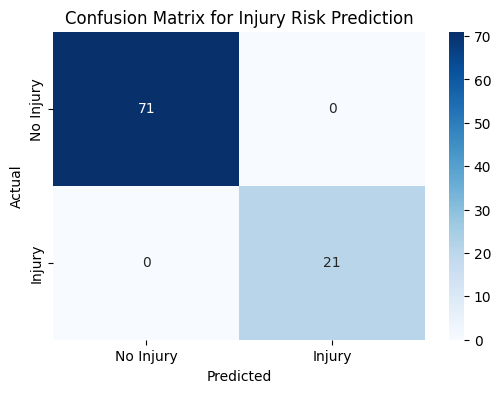

In [9]:
# Confusion Matrix for Injury Risk Prediction
conf_matrix_injury = confusion_matrix(y_test_injury, y_pred_injury)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix_injury, annot=True, fmt='d', cmap='Blues', xticklabels=['No Injury', 'Injury'], yticklabels=['No Injury', 'Injury'])
plt.title('Confusion Matrix for Injury Risk Prediction')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [10]:
# Model 2: Recovery Score Prediction (RandomForestRegressor)
recovery_model = RandomForestRegressor(n_estimators=100, random_state=42)
recovery_model.fit(X_train_scaled, y_train_recovery)

# Predict and evaluate recovery score model
y_pred_recovery = recovery_model.predict(X_test_scaled)
print('Recovery Score Prediction Performance:')
print(f'Mean Squared Error for Recovery Score: {mean_squared_error(y_test_recovery, y_pred_recovery)}')
print(f'R-squared for Recovery Score: {r2_score(y_test_recovery, y_pred_recovery)}')

ValueError: Input y contains NaN.

In [ ]:
# Hyperparameter Tuning for Injury Risk Prediction using GridSearchCV
param_grid_injury = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search_injury = GridSearchCV(estimator=RandomForestClassifier(random_state=42), param_grid=param_grid_injury, cv=3, verbose=2, n_jobs=-1)
grid_search_injury.fit(X_train_scaled, y_train_injury)

print('Best parameters for Injury Risk model:', grid_search_injury.best_params_)


In [11]:
# Hyperparameter Tuning for Recovery Score Prediction using GridSearchCV
param_grid_recovery = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search_recovery = GridSearchCV(estimator=RandomForestRegressor(random_state=42), param_grid=param_grid_recovery, cv=3, verbose=2, n_jobs=-1)
grid_search_recovery.fit(X_train_scaled, y_train_recovery)

print('Best parameters for Recovery Score model:', grid_search_recovery.best_params_)


Fitting 3 folds for each of 108 candidates, totalling 324 fits


ValueError: 
All the 324 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
324 fits failed with the following error:
Traceback (most recent call last):
  File "d:\Sports-Analytics-Streamlit\sports_analytics\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "d:\Sports-Analytics-Streamlit\sports_analytics\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "d:\Sports-Analytics-Streamlit\sports_analytics\Lib\site-packages\sklearn\ensemble\_forest.py", line 360, in fit
    X, y = validate_data(
           ^^^^^^^^^^^^^^
  File "d:\Sports-Analytics-Streamlit\sports_analytics\Lib\site-packages\sklearn\utils\validation.py", line 2961, in validate_data
    X, y = check_X_y(X, y, **check_params)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "d:\Sports-Analytics-Streamlit\sports_analytics\Lib\site-packages\sklearn\utils\validation.py", line 1387, in check_X_y
    y = _check_y(y, multi_output=multi_output, y_numeric=y_numeric, estimator=estimator)
        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "d:\Sports-Analytics-Streamlit\sports_analytics\Lib\site-packages\sklearn\utils\validation.py", line 1397, in _check_y
    y = check_array(
        ^^^^^^^^^^^^
  File "d:\Sports-Analytics-Streamlit\sports_analytics\Lib\site-packages\sklearn\utils\validation.py", line 1107, in check_array
    _assert_all_finite(
  File "d:\Sports-Analytics-Streamlit\sports_analytics\Lib\site-packages\sklearn\utils\validation.py", line 120, in _assert_all_finite
    _assert_all_finite_element_wise(
  File "d:\Sports-Analytics-Streamlit\sports_analytics\Lib\site-packages\sklearn\utils\validation.py", line 169, in _assert_all_finite_element_wise
    raise ValueError(msg_err)
ValueError: Input y contains NaN.


In [ ]:
# Feature Importance for Injury Risk Model
feature_importance_injury = pd.DataFrame({
    'Feature': X.columns,
    'Importance': injury_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

print('Top 10 Features for Injury Risk Prediction:')
print(feature_importance_injury.head(10))


In [ ]:
# Feature Importance for Recovery Score Model
feature_importance_recovery = pd.DataFrame({
    'Feature': X.columns,
    'Importance': recovery_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

print('Top 10 Features for Recovery Score Prediction:')
print(feature_importance_recovery.head(10))


In [ ]:
# Example prediction
example_data = {
    'Total Distance': [1500],
    'Metres Per Minute': [85],
    'Distance Zone 1': [400],
    'Distance Zone 2': [600],
    'Distance Zone 3': [300],
    'Distance Zone 4': [200],
    'Decelerations Zone 1': [5],
    'Decelerations Zone 2': [3],
    'Decelerations Zone 3': [2],
    'Decelerations Zone 4': [1],
    'HML Distance': [250],
    'Average Step Impact Left (g)': [500],
    'Average Step Impact Right (g)': [500],
    'Step Balance': [0.85],
    'HML Efforts': [20],
    'Explosive Distance': [150],
    'Energy': [9],
    'Sleep Quality': [9],
    'Stress': [5],
    'Soreness': [3],
    'Total Score': [35],
    'Max Game Total Distance': [12000],
    'Max Game High Speed Running': [1000],
    'Position_Midfielder': [1],  # Example for Midfielder (one-hot encoded)
}

example_df = pd.DataFrame(example_data)

# Scale the example data
example_scaled = scaler.transform(example_df)

# Predict injury risk and recovery score
pred_injury = injury_model.predict(example_scaled)
pred_recovery = recovery_model.predict(example_scaled)

print(f'Predicted Injury Risk: {pred_injury[0]}')
print(f'Predicted Recovery Score: {pred_recovery[0]}')